<a href="https://colab.research.google.com/github/seyeonJeong/america_sign_language_classifier/blob/main/america_sign_language_cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_17 (Conv2D)          (None, 26, 26, 32)        320       
                                                                 
 conv2d_18 (Conv2D)          (None, 24, 24, 16)        4624      
                                                                 
 max_pooling2d_10 (MaxPooli  (None, 12, 12, 16)        0         
 ng2D)                                                           
                                                                 
 conv2d_19 (Conv2D)          (None, 10, 10, 8)         1160      
                                                                 
 max_pooling2d_11 (MaxPooli  (None, 5, 5, 8)           0         
 ng2D)                                                           
                                                                 
 dropout_5 (Dropout)         (None, 5, 5, 8)          

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


103/103 [==============================] - 1s 9ms/step - loss: 0.6717 - accuracy: 0.7840 - val_loss: 0.2261 - val_accuracy: 0.9382
Epoch 3/30
103/103 [==============================] - 1s 9ms/step - loss: 0.2924 - accuracy: 0.9045 - val_loss: 0.0692 - val_accuracy: 0.9926
Epoch 4/30
103/103 [==============================] - 1s 9ms/step - loss: 0.1598 - accuracy: 0.9476 - val_loss: 0.0261 - val_accuracy: 0.9980
Epoch 5/30
103/103 [==============================] - 1s 10ms/step - loss: 0.1028 - accuracy: 0.9681 - val_loss: 0.0114 - val_accuracy: 0.9991
Epoch 6/30
103/103 [==============================] - 1s 11ms/step - loss: 0.0693 - accuracy: 0.9795 - val_loss: 0.0077 - val_accuracy: 0.9999
Epoch 7/30
103/103 [==============================] - 1s 10ms/step - loss: 0.0528 - accuracy: 0.9840 - val_loss: 0.0038 - val_accuracy: 1.0000
Epoch 8/30
103/103 [==============================] - 1s 9ms/step - loss: 0.0448 - accuracy: 0.9862 - val_loss: 0.0021 - val_accuracy: 1.0000
Epoch 9/30
103

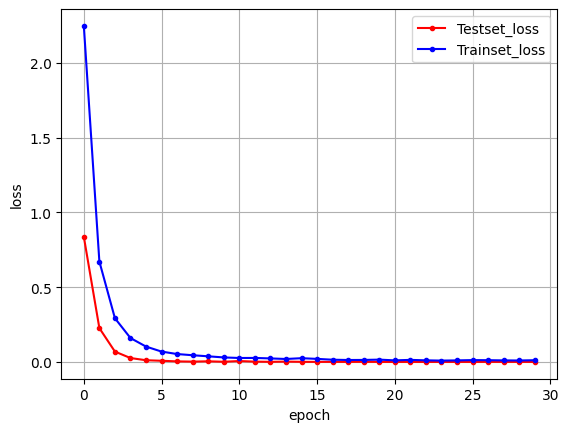

In [ ]:
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

import numpy as np
import matplotlib.pyplot as plt


# test 파일 불러오기
test_data = np.loadtxt("/content/sign_mnist_test.csv", delimiter=",")

# x와 y split (0번째 열은 class)
test_x = test_data[:,1:785]
test_y = test_data[:,0]

# train 파일 불러오기
train_data = np.loadtxt("/content/sign_mnist_train.csv", delimiter=",")

train_x = train_data[:,1:785]
train_y = train_data[:,0]

# 입력층이 컨볼루션 층이기 때문에, 28*28*1(1은 흑백 3은 컬러)로 reshape
# 255로 나누는 이유는 일종의 정규화 tensorflow에서는 0~1사이의 값에서 성능이 좋다고 한다.
test_x = test_x.reshape(test_x.shape[0], 28, 28, 1).astype('float64') / 255
train_x = train_x.reshape(train_x.shape[0],28, 28, 1).astype('float64') / 255

# 26개의 원-핫 인코딩벡터로 바꿔준다.
train_y = to_categorical(train_y, 26)
test_y = to_categorical(test_y, 26)

# CNN 구현
# conv layer -> conv layer -> pooling -> conv layer -> pooling -> FC -> FC (softmax) 의 구조
# 다중 분류 모델이므로 activation 으로 softmax 활용

model = Sequential()
model.add(Conv2D(32,kernel_size = (3,3),input_shape = (28,28,1), activation = 'relu'))
model.add(Conv2D(16,(3,3), activation = 'relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(8,(3,3), activation= 'relu'))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(1000, activation='relu'))
model.add(Dense(26, activation = 'softmax'))
model.summary()

# loss 함수는 categorical_crossentropy, optimizer은 adam 사용
model.compile(loss='categorical_crossentropy', optimizer = 'adam', metrics=['accuracy'])

# 모델 저장 및 early stopping (val_loss를 기준으로 10회 동안 변동이 없으면 학습이 종료된다.)
modelpath = "./AME_SIGN_MNIST_MLP.hdf5"
checkpoint = ModelCheckpoint(filepath=modelpath, monitor='val_loss', verbose=0, save_best_only = True)
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=10)

# validation 25% , epochs 30회, batch_size = 200으로 진행
history = model.fit(train_x, train_y, validation_split=0.25, epochs=30, batch_size = 200, verbose=1, callbacks=[checkpoint, early_stopping_callback])

# test에 대한 정확도
print("\n Test Accuracy: %.4f" % (model.evaluate(test_x, y_test)[1]))

y_vloss = history.history['val_loss']
y_loss = history.history['loss']

x_len = np.arange(len(y_loss))
plt.plot(x_len, y_vloss, marker='.', c="red", label='Testset_loss')
plt.plot(x_len, y_loss, marker='.', c="blue", label='Trainset_loss')

plt.legend(loc='upper right')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()


In [ ]:

# 100개의 case 중 예측값과 실제 class 사이의 몇개의 불일치가 있는지 출력해줌
predictions = model.predict(test_x)

cnt = 0
for i in range(100):
    if np.argmax(predictions[i]) != np.argmax(test_y[i]):
        cnt += 1

print("100개의 case 중 %d 개 불일치 " % (cnt))

225/225 [==============================] - 0s 2ms/step
100개의 case 중 8 개 불일치 
